### Backtesting for BUY HODL vs DCA

Buy-and-hold and dollar cost averaging (DCA) are two different investment strategies. This notebook compares the performance of these two strategies.

Buy-and-hold refers to buying assets at the start of the time period and holding the assets forever. 

DCA refers to buying the same value of assets at regular intervals.

In [1]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import os

pd.options.display.max_columns=300
pd.options.display.max_rows=100


Dataset is SPY (S&P 500 ETF).

In [2]:
misc.get_price_data('SPY')
df = pd.read_csv('SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df

,open,high,low,close,adjclose,volume,ticker
date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218216,1003200,SPY
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451391,201300,SPY
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720423,529400,SPY
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828053,531500,SPY
...,...,...,...,...,...,...,...
2023-01-27,403.660004,408.160004,403.440002,405.679993,405.679993,68280700,SPY
2023-01-30,402.799988,405.130005,400.279999,400.589996,400.589996,74202000,SPY
2023-01-31,401.130005,406.529999,400.769989,406.480011,406.480011,86811800,SPY


BUY_HOLD => Buy on the 1st day (1993-01-29) and hold forever

DCA      => Buy every n days (DCA period) with equal amount of cash

All calculations are made based on adjusted close to take into dividends.

In [3]:
# Starting cash
starting_cash = 10000
df['cash'] = 0
df.loc[df.index[0], 'cash'] = starting_cash


# buy_hold benchmark
# buy on close of 1st day
# use adjclose to account for dividends
buy_hold_position = starting_cash / df['adjclose'][0]
df['buy_hold_total'] = buy_hold_position * df['adjclose']

# daily returns
df['buy_hold_daily_return'] = (df['buy_hold_total'] - df['buy_hold_total'].shift(1)) / df['buy_hold_total'].shift(1)

# peak
df['buy_hold_peak'] = df['buy_hold_total'][0]

# accummulated return
df['buy_hold_return'] = df['buy_hold_total'] / starting_cash - 1

for i in range(1, len(df)):
    # update peak
    if df['buy_hold_total'][i] > df['buy_hold_peak'][i - 1]:
        df.loc[df.index[i], 'buy_hold_peak'] = df['buy_hold_total'][i]
    else:
        df.loc[df.index[i], 'buy_hold_peak'] = df['buy_hold_peak'][i - 1]
# drawdown
df['buy_hold_drawdown'] = (df['buy_hold_total'] - df['buy_hold_peak']) / df['buy_hold_peak']



# dca benchmark
# divide history into n blocks of unit length t and invest starting_cash / n amount every t days
dca_period = 20
dca_num = len(df) / dca_period
dca_amount = np.floor(starting_cash / dca_num)

# cash remaining
dca_cash_remaining = starting_cash
df['dca_total'] = starting_cash
df['dca_peak'] = starting_cash
df['dca_drawdown'] = 0
dca_position = 0
df['dca_assets'] = 0
df['dca_cash'] = starting_cash

for i in range(1, len(df)):
    # invest every t days    
    if i % dca_period == 1:
        dca_position += dca_amount / df['adjclose'][i]
        dca_cash_remaining -= dca_amount
    # assets
    df.loc[df.index[i], 'dca_assets'] = dca_position * df['adjclose'][i]
    # cash
    df.loc[df.index[i], 'dca_cash'] = dca_cash_remaining
    # total
    df.loc[df.index[i], 'dca_total'] = df['dca_assets'][i] + df['dca_cash'][i]
    # peak
    if df['dca_total'][i] > df['dca_peak'][i - 1]:
        df.loc[df.index[i], 'dca_peak'] = df['dca_total'][i]
    else:
        df.loc[df.index[i], 'dca_peak'] = df['dca_peak'][i - 1]
# daily returns
df['dca_daily_return'] = (df['dca_total'] - df['dca_total'].shift(1)) / df['dca_total'].shift(1)
# accummulated returns
df['dca_return'] = (df['dca_total'] - starting_cash) / starting_cash
# drawdown
df['dca_drawdown'] = (df['dca_total'] - df['dca_peak']) / df['dca_peak']

# df.to_csv('test.csv')

df

,open,high,low,close,adjclose,volume,ticker,cash,buy_hold_total,buy_hold_daily_return,buy_hold_peak,buy_hold_return,buy_hold_drawdown,dca_total,dca_peak,dca_drawdown,dca_assets,dca_cash,dca_daily_return,dca_return
date,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218216,1003200,SPY,10000,10000.000000,NaN,10000.000000,0.000000,0.000000,10000.000000,10000.000000,0.000000,0.000000,10000,NaN,0.000000
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY,0,10071.129018,0.007113,10071.129018,0.007113,0.000000,10000.000000,10000.000000,0.000000,26.000000,9974,0.000000,0.000000
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451391,201300,SPY,0,10092.463035,0.002118,10092.463035,0.009246,0.000000,10000.055077,10000.055077,0.000000,26.055077,9974,0.000006,0.000006
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720423,529400,SPY,0,10199.144461,0.010570,10199.144461,0.019914,0.000000,10000.330489,10000.330489,0.000000,26.330489,9974,0.000028,0.000033
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828053,531500,SPY,0,10241.823839,0.004185,10241.823839,0.024182,0.000000,10000.440672,10000.440672,0.000000,26.440672,9974,0.000011,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27,403.660004,408.160004,403.440002,405.679993,405.679993,68280700,SPY,0,160867.839978,0.002298,186406.397769,15.086784,-0.137005,49177.340108,56897.420491,-0.135684,49005.340108,172,0.002290,3.917734
2023-01-30,402.799988,405.130005,400.279999,400.589996,400.589996,74202000,SPY,0,158849.459158,-0.012547,186406.397769,14.884946,-0.147833,48562.478626,56897.420491,-0.146491,48390.478626,172,-0.012503,3.856248
2023-01-31,401.130005,406.529999,400.769989,406.480011,406.480011,86811800,SPY,0,161185.078245,0.014703,186406.397769,15.118508,-0.135303,49273.980736,56897.420491,-0.133986,49101.980736,172,0.014651,3.927398


## Returns

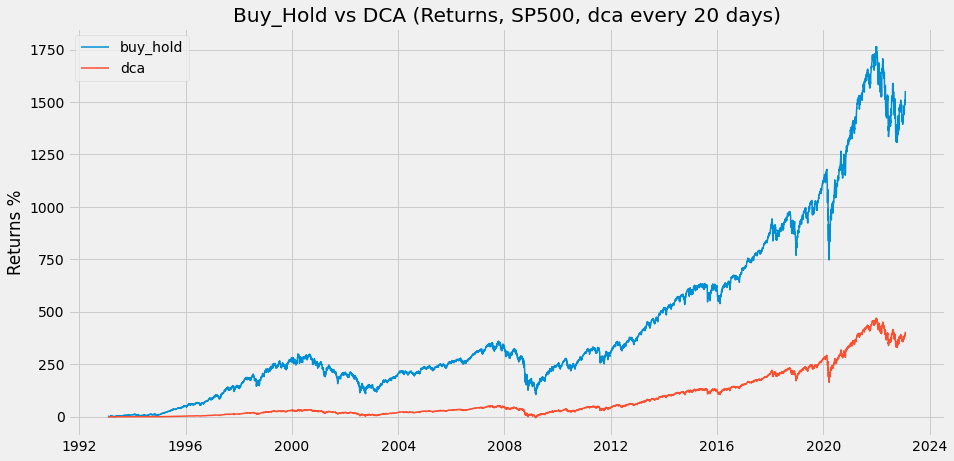

In [4]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_return'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_return'] * 100, linewidth=1.5, label='dca')
    
    plt.title("Buy_Hold vs DCA (Returns, SP500, dca every 20 days)")
    plt.ylabel('Returns %')
    plt.legend()

## Drawdown

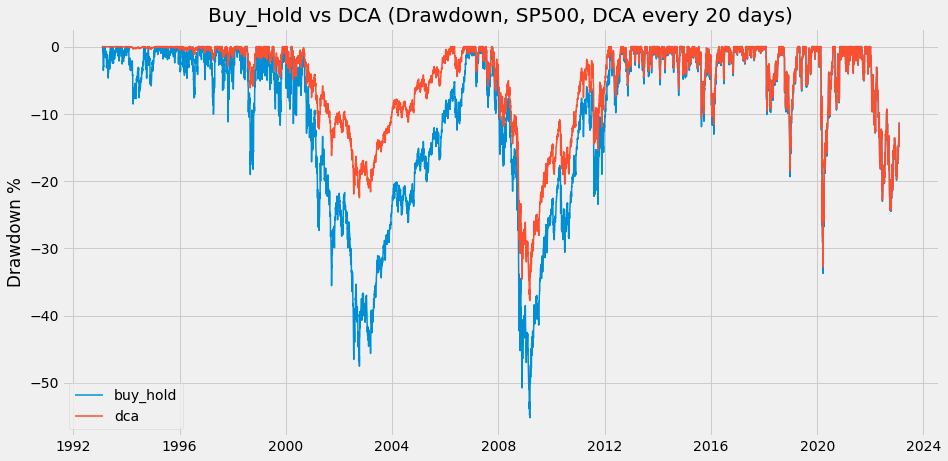

In [5]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_drawdown'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_drawdown'] * 100, linewidth=1.5, label='dca')
    


    plt.title("Buy_Hold vs DCA (Drawdown, SP500, DCA every " + str(dca_period) + " days)")
    plt.ylabel('Drawdown %')
    plt.legend()


## Drawdown Distribution

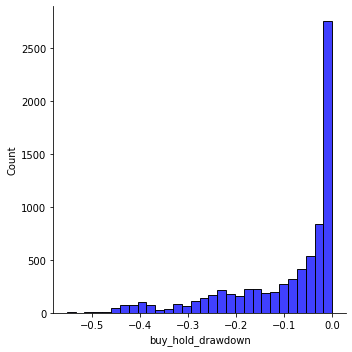

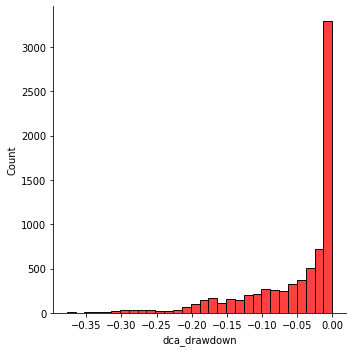

In [6]:
buy_hold = sns.displot(df['buy_hold_drawdown'], color='blue', bins=30)
dca = sns.displot(df['dca_drawdown'], color='red', bins=30)

## Annual Returns Distribution

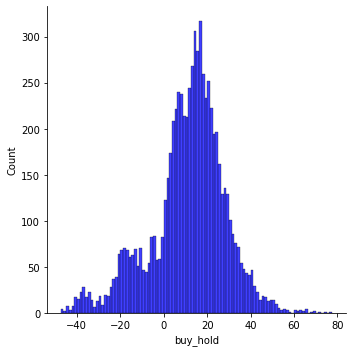

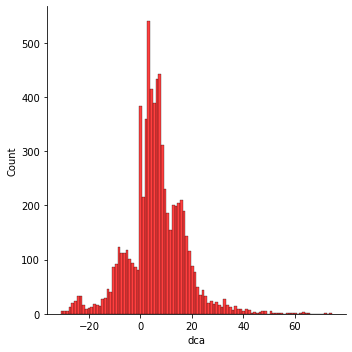

In [7]:
# Rolling Annual Returns
bh_annual_returns = np.array(((df['buy_hold_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)
dca_annual_returns = np.array(((df['dca_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)

annual_returns = pd.DataFrame({'buy_hold': bh_annual_returns, 'dca': dca_annual_returns})

sns.displot(annual_returns['buy_hold'], color='blue', bins=100)
sns.displot(annual_returns['dca'], color='red', bins=100)

## Statistics

In [8]:
num_years = len(df) / 252

print('Buy_HODL')
print("Total Returns:              " + "{:.2f}".format(df['buy_hold_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['buy_hold_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['buy_hold_drawdown'] * 100)) + " %")
bh_dr_mean = np.mean(df['buy_hold_daily_return'])
bh_dr_var = np.var(df['buy_hold_daily_return'])
bh_ar_mean = (bh_dr_mean + 1) ** 252 - 1
bh_ar_var = bh_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(bh_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(bh_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(bh_ar_mean - 2.33 * np.sqrt(bh_ar_var) * 100) + " %")

print()

print('DCA')
print("Total Returns:              " + "{:.2f}".format(df['dca_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['dca_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['dca_drawdown'] * 100)) + " %")
dca_dr_mean = np.mean(df['dca_daily_return'])
dca_dr_var = np.var(df['dca_daily_return'])
dca_ar_mean = (dca_dr_mean + 1) ** 252 - 1
dca_ar_var = dca_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(dca_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(dca_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(dca_ar_mean - 2.33 * np.sqrt(dca_ar_var) * 100) + " %")

Buy_HODL
Total Returns:              1552.42 %
CAGR:                       9.80 %
Maximum Drawdown:          -55.19 %
Annual Returns Mean:        11.79 %
Annual Returns Std Dev:     4.75 %
99% Worst Annual Drawdown: -10.95 %

DCA
Total Returns:              405.10 %
CAGR:                       5.55 %
Maximum Drawdown:          -37.77 %
Annual Returns Mean:        6.38 %
Annual Returns Std Dev:     3.14 %
99% Worst Annual Drawdown: -7.26 %


### Remarks

Dollar cost averaging is a strategy commonly recommended for new investors, where the investor buys a specific dollar-value of assets at regular intervals. 

There are purportedly 2 advantages of DCA:
1. When asset prices are low, the specific dollar-value can purchase more units of the asset. The investor therefore buys more units of the asset when prices are low, and less units of the asset when prices are high, thereby lowering the cost basis of the asset. 
2. The purchase of assets are spread over a long time, therefore the investor avoids buying at the peak of the market, or just before a crash.

From the simulation, I find that these 2 advantages are minimal and balanced out by a huge difference in total return at the end of the investment period. 

The total return differ by a factor of 3.83 (CAGR differ by 4.15%) in return of a mere 1.61% decrease in annual volatility.

Moreover, from the graph of drawdown vs time, we note that the drawdown at the end of the investment period is the same. This is because at the end of the period, all cash are also invested in the asset and therefore there is no significant difference between DCA and buy-hold. This means that any market downturn at the end of the investment period is equally devastating to both strategiess. Since investors are looking to cash out at the end of the investment lifecycle, I argue that the drawdown at the end of investment period is most meaningful and DCA performs as bad as buy-hold in this regard, even though it might have reduced paper losses previously.
